In [1]:
import cloudpickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import sys 
mpl.rcParams['figure.dpi'] = 144
import numpy as np
import pyomo
import pyomo.environ as pyo
print(pyomo.__version__)
from pyomo.gdp import *
from pyomo.environ import value
import operator


5.7.1


In [2]:
linkRates = pd.read_hdf('out/merged.h5', 'linkRates')
linkRates

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
0,12,240.4057,7.0,1,4.666667,1.333333,332.0,3,False,7.692982,1098.997486
1,13,240.2424,7.0,1,3.333333,4.666667,314.0,3,False,7.687757,1098.250971
2,14,142.4875,5.0,1,6.500000,0.000000,360.0,4,False,4.559600,911.920000
3,15,142.2112,5.0,1,6.500000,6.500000,366.5,4,False,4.550758,910.151680
4,16,176.1495,6.0,1,7.000000,6.000000,374.0,5,False,5.636784,939.464000
...,...,...,...,...,...,...,...,...,...,...,...
105,894,157.3610,8.0,29,2.333333,3.666667,7465.0,3,True,5.035552,629.444000
106,907,186.1277,8.0,30,4.000000,2.000000,7746.0,3,True,5.956086,744.510800
107,920,170.0694,9.0,30,1.000000,4.000000,7700.0,3,True,5.442221,604.691200
108,922,169.7657,9.0,30,3.000000,4.000000,7732.0,3,True,5.432502,603.611378


In [3]:
n_doubles = len(linkRates[ linkRates.doubleDAQlpGBT ])
n_singles = len(linkRates[ ~linkRates.doubleDAQlpGBT ])
n_links = n_singles + 2*n_doubles
print(f"""
There is a total of {n_links} lpGBT links:
 - {n_singles} singles, and
 - {n_doubles} doubles (with one ECOND straddling the pair)
""")



There is a total of 1508 lpGBT links:
 - 1288 singles, and
 - 110 doubles (with one ECOND straddling the pair)



In [4]:
sortedRates = linkRates[ ~linkRates.doubleDAQlpGBT ].sort_values(by='EvSize')
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
SizeSortedRates


,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
1158,1378,12.1890,5.0,40,15.0,2.0,10482.0,1,False,0.390048,78.009600
1160,1380,12.1951,5.0,40,15.0,4.0,10484.0,1,False,0.390243,78.048640
1162,1382,12.1958,5.0,40,15.0,6.0,10486.0,1,False,0.390266,78.053120
1159,1379,12.1976,5.0,40,15.0,3.0,10483.0,1,False,0.390323,78.064640
1164,1384,12.1992,5.0,40,15.0,8.0,10488.0,1,False,0.390374,78.074880
...,...,...,...,...,...,...,...,...,...,...,...
40,192,461.9141,13.0,7,3.0,0.0,1840.0,3,True,14.781251,1137.019323
13,62,467.5174,13.0,3,3.0,3.0,819.0,3,True,14.960557,1150.812062
12,60,467.6358,13.0,3,3.0,0.0,816.0,3,True,14.964346,1151.103508
24,124,483.2248,13.0,5,3.0,0.0,1328.0,3,True,15.463194,1189.476431


In [5]:
assert( len(sortedRates)%2 == 0 )

In [6]:
linkRates['nDAQlpGBT'] = linkRates.doubleDAQlpGBT.apply(lambda d: 2 if d else 1)

In [7]:
nFPGA = 16 #max=28
#runNumber = 3 #max=4
splitNumber=8

warmStart=False
hardStart=True

#---------------------------------------------------

nGBTSingles = int((1288*nFPGA)/nFPGA)
#nGBTSingles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])
nGBTDoubles = int((110*nFPGA)/nFPGA)
#nGBTDoubles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])
#maxSlinkRate = 300
nSlinks = nFPGA*12  #192

#---------------------------------------------------

nGBTs = nGBTSingles + nGBTDoubles #ERDEM - NEDEN 2*nGBTDoubles değil?
maxGBTsPerSlink = 12
SlinkPerFPGA = 12



In [8]:
print(f"""
Toy problem parameters:
- {nGBTs} lpGBT inputs.
  - {nGBTSingles} lpGBT singles, and
  - {nGBTDoubles} lpGBT doubles.
- {nSlinks} Slink outputs.
  - Up to {maxGBTsPerSlink} lpGBTs served by each SLink.
""")
print(f"""
 - {nFPGA} FPGAs and
 - {SlinkPerFPGA} Slinks served by each FPGA.
""")



Toy problem parameters:
- 1398 lpGBT inputs.
  - 1288 lpGBT singles, and
  - 110 lpGBT doubles.
- 192 Slink outputs.
  - Up to 12 lpGBTs served by each SLink.


 - 16 FPGAs and
 - 12 Slinks served by each FPGA.



In [9]:
def split_dict_equally(input_dict, chunks=2):
    "Splits dict by keys. Returns a list of dictionaries."
    # prep with empty dicts
    return_list = [dict() for idx in range(chunks)]
    idx = 0
    for k,v in input_dict.items():
        return_list[idx][k] = v
        if idx < chunks-1:  # indexes start at 0
            idx += 1
        else:
            idx = 0
    return return_list

In [10]:
mode='HtoL' #{'HtoL': high to low, 'LtoH': low to high, 'Ht': highest, 'Lt': lowest}

lowS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTSingles/3)].to_dict()
medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)-int(nGBTSingles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)+int(nGBTSingles/6)].to_dict()
if nFPGA==nFPGA:
    medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][int(nGBTSingles/3):-1*int(nGBTSingles/3)].to_dict()
highS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTSingles/3):].to_dict()

lowD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTDoubles/3)].to_dict()
medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)-int(nGBTDoubles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)+int(nGBTDoubles/6)].to_dict()
if nFPGA==nFPGA:
    medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(nGBTDoubles/3):-1*int(nGBTDoubles/3)].to_dict()
highD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTDoubles/3):].to_dict()

#------------------------------------------------------------

lowS_1={}
medS_1={}
highS_1=highS

lowD_1=lowD
medD_1=medD
highD_1=highD

    
#------------------------------------------------------------

if mode=='LtoH':
    medS_1.update(highS_1)
    lowS_1.update(medS_1)
    
    medD_1.update(highD_1)
    lowD_1.update(medD_1)
    
    singleGBTRates_1 = lowS_1
    doubleGBTRates_1 = lowD_1
if mode=='HtoL':
    medS_1.update(lowS_1)
    highS_1.update(medS_1)
    
    medD_1.update(lowD_1)
    highD_1.update(medD_1)
    
    singleGBTRates_1 = highS_1
    doubleGBTRates_1 = highD_1
if mode=='Lt':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
    singleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict())[1]
    doubleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict())[1]
if mode=='Ht':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=False)
    singleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict())[1]
    doubleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict())[1]

print(len(singleGBTRates_1))
print(singleGBTRates_1)
print(len(doubleGBTRates_1))
#print(doubleGBTRates_1)


429
{364: 101.6522, 712: 101.7297, 775: 101.7515, 774: 101.75710000000001, 703: 101.79149999999998, 366: 101.8058, 616: 101.85329999999999, 617: 101.9138, 1024: 102.2541, 1025: 102.35079999999999, 1010: 102.49589999999998, 1011: 102.5005, 333: 102.8258, 330: 102.91199999999999, 331: 102.9726, 542: 102.97670000000001, 543: 103.01419999999999, 332: 103.0669, 1119: 103.1788, 1116: 103.2344, 727: 103.2387, 725: 103.3066, 759: 103.6225, 757: 103.7158, 217: 103.9479, 648: 103.98109999999998, 649: 103.9851, 638: 104.067, 216: 104.11319999999999, 373: 104.1889, 639: 104.1986, 372: 104.23060000000001, 914: 104.66792, 915: 104.75259, 553: 104.79920000000001, 552: 104.86320000000002, 969: 104.9403, 26: 104.99390000000001, 970: 105.05099999999999, 27: 105.0616, 956: 105.6527, 955: 105.7606, 457: 105.8179, 455: 105.9285, 454: 105.9863, 456: 106.0684, 663: 106.193, 241: 106.2282, 661: 106.2782, 240: 106.3634, 695: 106.52770000000001, 693: 106.5575, 482: 106.587, 510: 106.64569999999999, 511: 106.712

In [11]:
totalRate = ( sum([i for i in singleGBTRates_1.values()])+sum([i for i in doubleGBTRates_1.values()]) )
print(f"""
Total lpGBT rate: {totalRate}
Average lpGBT rate: {totalRate /len(singleGBTRates_1)+len(doubleGBTRates_1)}
Average Slink rate: {totalRate / nSlinks}
""")
#ERDEM - Average lpGBT rate'de yanlışlıkla iki kere len(doubleGBTRates_1) yazılmış. Düzeltip len(singleGBTRates_1) yaptım. 
#ERDEM - Average Slink rate ile çözümümüz sonucu oluşan average Slink Rate'i karşılaştırabiliriz.


Total lpGBT rate: 100269.13486999997
Average lpGBT rate: 343.727587109557
Average Slink rate: 522.2350774479165



In [12]:
#ERDEM - Yeni cell ekledim.
print(singleGBTRates_1)
print("\n ******** \n")
print(doubleGBTRates_1)

{364: 101.6522, 712: 101.7297, 775: 101.7515, 774: 101.75710000000001, 703: 101.79149999999998, 366: 101.8058, 616: 101.85329999999999, 617: 101.9138, 1024: 102.2541, 1025: 102.35079999999999, 1010: 102.49589999999998, 1011: 102.5005, 333: 102.8258, 330: 102.91199999999999, 331: 102.9726, 542: 102.97670000000001, 543: 103.01419999999999, 332: 103.0669, 1119: 103.1788, 1116: 103.2344, 727: 103.2387, 725: 103.3066, 759: 103.6225, 757: 103.7158, 217: 103.9479, 648: 103.98109999999998, 649: 103.9851, 638: 104.067, 216: 104.11319999999999, 373: 104.1889, 639: 104.1986, 372: 104.23060000000001, 914: 104.66792, 915: 104.75259, 553: 104.79920000000001, 552: 104.86320000000002, 969: 104.9403, 26: 104.99390000000001, 970: 105.05099999999999, 27: 105.0616, 956: 105.6527, 955: 105.7606, 457: 105.8179, 455: 105.9285, 454: 105.9863, 456: 106.0684, 663: 106.193, 241: 106.2282, 661: 106.2782, 240: 106.3634, 695: 106.52770000000001, 693: 106.5575, 482: 106.587, 510: 106.64569999999999, 511: 106.7120999

In [13]:
#maxSlinkRatePyomo = (totalRate / nSlinks)*1.8
maxSlinkRatePyomo = 900
#maxSlinkRatePyomo = (totalRate / (len(doubleGBTRates_1)+len(singleGBTRates_1)))*1.5
maxSlinkRateGekko = (totalRate / nSlinks)*1.4
print("maxSlinkRatePyomo: ",maxSlinkRatePyomo)
#print("maxSlinkRateGekko: ",maxSlinkRateGekko)
avSlinkEvSize = totalRate/nSlinks


maxSlinkRatePyomo:  900


In [14]:
from dataclasses import dataclass
@dataclass
class Slink:
    totalEvSize: float
    linkList: list

from operator import attrgetter
def assign_link(link, Slinks):
    Slinks.sort(key=attrgetter('totalEvSize'))
    target = Slinks[0]
    target.linkList.append(link[0])
    target.totalEvSize += link[1]
    return Slinks

Slinks = [Slink(totalEvSize=0, linkList=[]) for _ in range(nSlinks)]
#for link in sortedLinkRates.itertuples(name='Link', index=False):
#    Slinks = assign_link(link, Slinks)

lpGBTs={}
lpGBTs.update(doubleGBTRates_1)
lpGBTs.update(singleGBTRates_1)
lpGBTs={k: v for k, v in sorted(lpGBTs.items(), key=lambda item: item[1],reverse=True)}
for link in lpGBTs.items():
    Slinks = assign_link(link, Slinks)

SlinkTotals = pd.DataFrame(data=[ Slink.totalEvSize for Slink in Slinks ], columns=['EvSize'])
print(SlinkTotals)


       EvSize
0    588.1347
1    486.5898
2    486.7434
3    486.7619
4    486.7637
..        ...
187  588.5197
188  588.8346
189  588.8561
190  588.8913
191  588.9186

[192 rows x 1 columns]


In [15]:
#ERDEM - Yeni cell ekledim.

# for link in lpGBTs.items():
#     print(link[1])

SlinkEvList = []

for Slink in Slinks:
    #print(Slink.totalEvSize)
    SlinkEvList.append(Slink.totalEvSize)

#print(SlinkEvList)

In [16]:
#ERDEM - Yeni cell ekledim.
import math

def variance(data, ddof=0):
    n = len(data)
    mean = sum(data)/n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

def stdev(data):
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev

std = stdev(SlinkEvList)

std = str(format(std, ".2f")) 

print(std) #ERDEM - Bu Slinklerimizin Std Dev'i. Matplotlib legend'ına koyabiliriz. Amacımız bunu minimize etmek.

37.39


C:\Users\erdem\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\erdem\anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


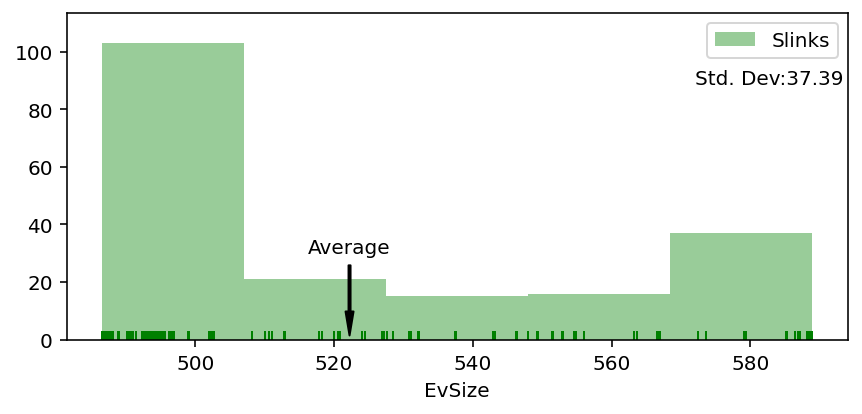

In [17]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    SlinkTotals['EvSize'],
    kde=False,
    rug=True,
    color = 'g',
    label='Slinks'
    )

plt.text(0.9, 0.8,"Std. Dev:" + str(std),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes) #ERDEM - Standard Deviation'ı legend'a ekledim.

plt.annotate('Average', xy=(avSlinkEvSize,0), xytext=(avSlinkEvSize, 30),  ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=4, width=1))
plt.legend()



In [18]:
model = pyo.ConcreteModel()

In [19]:
Single1=[str(k) for k in singleGBTRates_1.keys()]
Double1 = [str(k) for k in doubleGBTRates_1.keys()]
Slink = [str(i) for i in range(1,nSlinks+1)]
FPGA = [str(i) for i in range(1,nFPGA+1)]
#print(Single1)
#print(Double1)
#print(Slink)
#print(FPGA)
GKavSlinkRate = (totalRate/nSlinks)

In [20]:
model.GKSingles1 = pyo.Var(Single1, Slink, initialize = 0, within = pyo.Binary)
model.GKDoubles1 = pyo.Var(Double1, Slink, initialize = 0, within = pyo.Binary)
model.GKSlinks = pyo.Var(Slink, FPGA, initialize = 0, within = pyo.Binary)


In [21]:
model.GKSingles1.fix()
model.GKDoubles1.fix()

In [22]:
#Enter the file path
path = './Runs/lows16FPGA_run2_part_thershold15001.pkl'

with open(path, mode='rb') as file:
    model = cloudpickle.load(file)

In [23]:
print("Average Slink Rate:", GKavSlinkRate)
print("Objective: ", value(model.objective))
model.objective.display()


Average Slink Rate: 522.2350774479165
Objective:  13.368369526614138
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 13.368369526614138


In [24]:
Single2_dict={}
for partNumber in range(9):
    singleGBTRates_2 = split_dict_equally(medS,8)[partNumber-1]

        #print('len(singleGBTRates_2): ',len(singleGBTRates_2))
        #print(singleGBTRates_2)


    Single2=[str(k) for k in singleGBTRates_2.keys()]
    Single2_dict[partNumber]=Single2
for partNumber in [1,2]:
    
    singleGBTRates_2 = split_dict_equally(lowS,2)[partNumber-1]
        
    Single2=[str(k) for k in singleGBTRates_2.keys()]
    Single2_dict[partNumber+8]=Single2
Single2_dict

{0: ['1273',
  '1179',
  '1289',
  '1185',
  '933',
  '1196',
  '1278',
  '887',
  '1050',
  '1161',
  '1290',
  '714',
  '985',
  '650',
  '1121',
  '1076',
  '797',
  '522',
  '952',
  '1089',
  '431',
  '910',
  '641',
  '576',
  '401',
  '971',
  '902',
  '828',
  '514',
  '1103',
  '993',
  '310',
  '425',
  '643',
  '740',
  '866',
  '679',
  '803',
  '912',
  '1053',
  '392',
  '833',
  '967',
  '710',
  '1055',
  '794',
  '581',
  '432',
  '644',
  '734',
  '826',
  '491',
  '312'],
 1: ['1200',
  '1194',
  '903',
  '1295',
  '1186',
  '1210',
  '1071',
  '1214',
  '1145',
  '683',
  '1158',
  '1221',
  '1169',
  '777',
  '944',
  '587',
  '493',
  '796',
  '674',
  '766',
  '608',
  '704',
  '911',
  '640',
  '1237',
  '861',
  '579',
  '798',
  '916',
  '512',
  '1104',
  '1046',
  '1224',
  '979',
  '642',
  '742',
  '865',
  '926',
  '800',
  '1009',
  '248',
  '390',
  '1236',
  '869',
  '711',
  '1056',
  '551',
  '550',
  '858',
  '647',
  '680',
  '827',
  '519',
  '517

In [25]:
Vars= {}
Slink=[]
for v in model.component_objects(pyo.Var, active=True):
    #print("Variable",v) 
    lpList=[]
    if v.name.startswith('GKSingles') or v.name.startswith('GKDoubles'):
        for index in v:
        #print ("   ",index, pyo.value(v[index]))
            if index[0] not in lpList:
                lpList.append(index[0])
                #print(index[0])
        Vars[v.name]=[lpList,v] # doctest: +SKIP
    elif v.name.startswith('GKSlinks'):
        for index in v:
            if index[0] not in Slink:
                Slink.append(index[0])

In [26]:
L1=[]
L2=[]
for k, v in Vars.items():
    L1.append(v[0])
    L2.append(v[1])
L3=SizeSortedRates.set_index('DAQlpGBT')["EvSize"].to_dict()
totalRate = sum([i for i in L3.values()])
nSlinks=len(Slink)
GKavSlinkRate = (totalRate/nSlinks)

In [27]:
#ERDEM - Yeni cell ekledim.
# print(Slink) 

C:\Users\erdem\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\erdem\anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


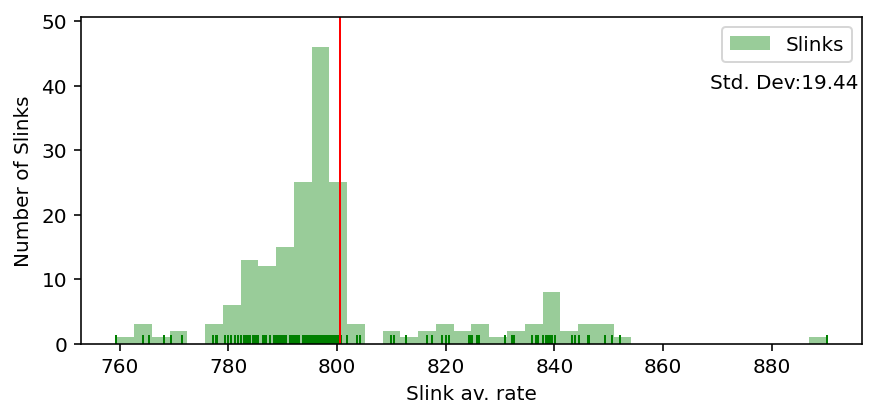

In [28]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1,L2):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
        #ilist -- o vars object için yani run için  GKsingles 2_3  mesela ayrılmış lpgbt rate id ler
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])

# ERDEM ---------------------------
slinkrates = [] 

for key in GK:
    slinkrates.append(GK[key])
    
#print(slinkrates) 

std = stdev(slinkrates)

std = str(format(std, ".2f")) #Bu Slinklerimizin Std Dev'i. Matplotlib legend'ına koyabiliriz. Amacımız bunu minimize etmek.

# ERDEM ---------------------------
    
    
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])

f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )

plt.text(0.9, 0.8,"Std. Dev:" + str(std),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes) #ERDEM - Standard Deviation'ı legend'a ekledim.

plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)

In [29]:
singleGBTRates_2_ALL={}
singleGBTRates_2_ALL.update(lowS)
singleGBTRates_2_ALL.update(medS)
#singleGBTRates_2_ALL.update()
singleGBTRates_2_ALL
Single2_ALL = [str(k) for k in singleGBTRates_2_ALL.keys()]

totalRate = ( sum([i for i in singleGBTRates_1.values()])+sum([i for i in singleGBTRates_2_ALL.values()])+sum([i for i in doubleGBTRates_1.values()]) )
GKavSlinkRate = (totalRate/nSlinks)
singleGBTRates_2_ALL

{1378: 12.189,
 1380: 12.1951,
 1382: 12.1958,
 1379: 12.1976,
 1384: 12.1992,
 1386: 12.2023,
 1387: 12.2093,
 1377: 12.2107,
 1385: 12.2131,
 1381: 12.2151,
 1376: 12.2246,
 1383: 12.2254,
 1366: 12.3632,
 1369: 12.3748,
 1368: 12.3769,
 1367: 12.3806,
 1365: 12.3828,
 1370: 12.3908,
 1372: 12.3921,
 1371: 12.3953,
 1373: 12.3994,
 1375: 12.4002,
 1374: 12.4012,
 1364: 12.4063,
 1354: 12.5755,
 1357: 12.5762,
 1362: 12.5774,
 1353: 12.5776,
 1356: 12.5809,
 1359: 12.5811,
 1355: 12.5839,
 1363: 12.5873,
 1358: 12.5907,
 1352: 12.5923,
 1360: 12.5927,
 1361: 12.6002,
 1350: 12.8867,
 1347: 12.8894,
 1346: 12.8947,
 1341: 12.8978,
 1351: 12.9001,
 1343: 12.9046,
 1344: 12.9048,
 1342: 12.9065,
 1348: 12.9106,
 1340: 12.9137,
 1345: 12.9169,
 1349: 12.9256,
 1114: 17.2101,
 1157: 17.2284,
 1402: 19.8778,
 1408: 19.8935,
 1409: 19.8945,
 1405: 19.8996,
 1401: 19.9019,
 1411: 19.9093,
 1403: 19.9098,
 1410: 19.9105,
 1404: 19.9125,
 1407: 19.9135,
 1400: 19.9139,
 1406: 19.918,
 1396: 20.

In [30]:
### all lpgbt dict####
all_lpgbts={}
all_lpgbts.update(singleGBTRates_2_ALL)
all_lpgbts.update(singleGBTRates_1)
all_lpgbts.update(doubleGBTRates_1)
len(all_lpgbts)
#all_lpgbts

1398

In [31]:
###slink_rate_dict###
slink_rate_dict=GK
#slink_rate_dict

In [32]:
def even_or_odd(slink):
    if slink_lpgbt_dict[slink]%2==0:
        return 2
    else:
        return 1

In [33]:
def double(lpgbt):
    if lpgbt in Double1:
        return 2

1
2
3
4
5
6
7
8
1
2


<ipython-input-34-041a47c7cab4>:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  hml2_single=np.array([hml_temp_single])
<ipython-input-34-041a47c7cab4>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  hml2_double=np.array([hml_temp_double])
<ipython-input-34-041a47c7cab4>:92: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


,Slink1,Slink2,Slink3,Slink4,Slink5,Slink6,Slink7,Slink8,Slink9,Slink10,...,Slink183,Slink184,Slink185,Slink186,Slink187,Slink188,Slink189,Slink190,Slink191,Slink192
lpgbt Rates,,,,,,,,,,,,,,,,,,,,,
Single Low,2,3,3,2,3,2,3,4,2,3,...,2,2,1,1,2,2,2,1,1,1
Single Mid,2,2,2,4,2,3,2,2,3,2,...,1,1,2,2,1,0,1,2,2,2
Single High,3,1,3,1,3,3,3,3,3,3,...,4,4,4,3,4,3,4,4,4,4
Double Low,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
Double Mid,1,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
Double High,1,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
Total Rate,838,796,794,790,799,788,797,837,795,852,...,788,839,771,793,816,764,817,795,792,780
Slink Total lpGBT,10,8,8,9,8,8,8,9,8,8,...,7,7,7,9,7,8,7,7,7,7


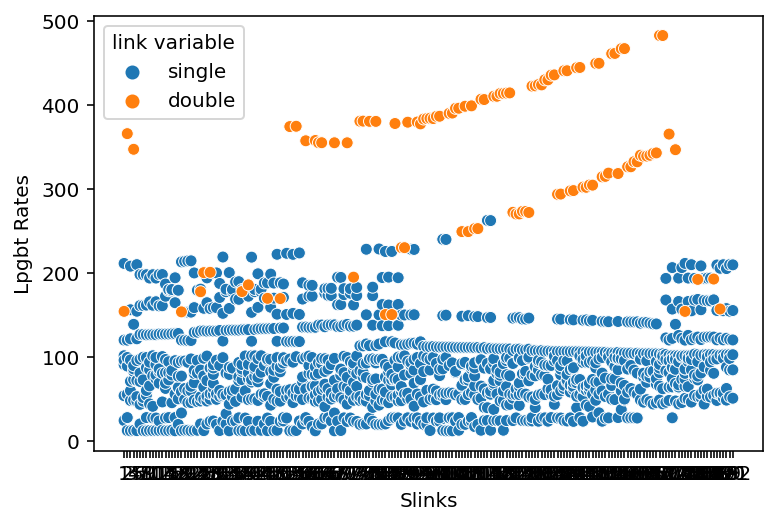

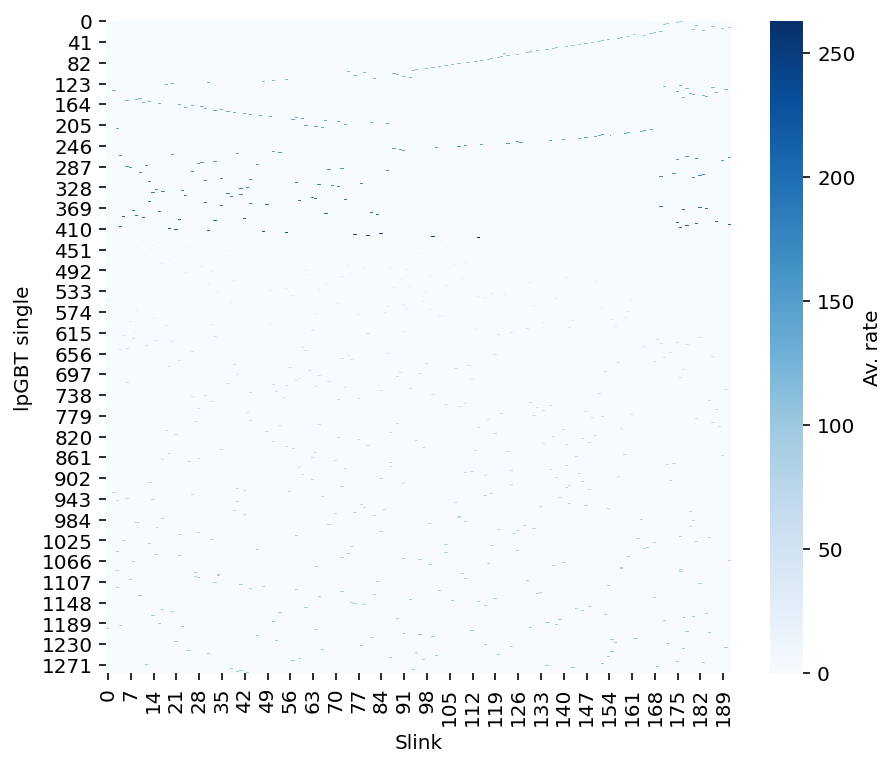

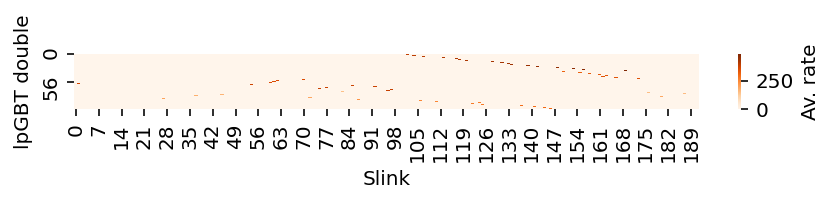

In [34]:
#def total_lpgbt_slink(): TOTAL LPGBT SLNK WORK
single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in singleGBTRates_1.values():
    s.append(i)
for i in singleGBTRates_2_ALL.values():
    s.append(i)
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in doubleGBTRates_1.values():
    d.append(i)
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    for i in hml_single[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_single.append(a)
hml2_single=np.array([hml_temp_single])

hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_double.append(a)
hml2_double=np.array([hml_temp_double])

df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Lpgbt Rates":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i]}
    df2_single=pd.DataFrame(c) 
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Lpgbt Rates":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i])}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)
sns_scatter=sns.scatterplot(data=df_together, x="Slinks", y="Lpgbt Rates", hue="link variable")
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#fig=sns_scatter.get_figure()
#plt.savefig("Swap_Total scatterplot low600 of 28.png")
   

###SİNGLE PART

(wd, ht) = (7, 6)
vmax = max(singleGBTRatesMAIN)
f, ax = plt.subplots(figsize=(wd, ht))
sns.heatmap(
    (singles.T * singleGBTRatesMAIN).T,
    cmap='Blues', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='Slink', ylabel='lpGBT single')

### DOUBLE PART

f, ax = plt.subplots(figsize=(wd, ht * (nGBTDoubles/nGBTSingles)))
vmax = max(doubleGBTRatesMAIN)
sns.heatmap(
    ((doubles.T) * doubleGBTRatesMAIN).T,
    cmap='Oranges', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='Slink', ylabel='lpGBT double')

### DATAFRAME PART

def create_dataframe():
    hml_double=(doubles.T*doubleGBTRatesMAIN).T
    hml_single=(singles.T * singleGBTRatesMAIN).T
    a=[]
    #slink_lpgbt_total_list=[]
    #slink_lpgbt_total_list2=[]
    for j in range(nSlinks):
        sum_low=0
        sum_mid=0
        sum_high=0
        sum_doub_low=0
        sum_doub_mid=0
        sum_doub_high=0
        list=[]
     
        for i in hml_single[:,j]:
            if i in lowS.values():
                sum_low+=1
        list.append(sum_low)
        for i in hml_single[:,j]:
            if i in medS.values():
                sum_mid+=1
        list.append(sum_mid)
        for i in hml_single[:,j]:
            if i in highS.values():
                sum_high+=1
        list.append(sum_high)
        for i in hml_double[:,j]:
            if i in lowD.values():
                sum_doub_low+=1
        list.append(sum_doub_low)
        for i in hml_double[:,j]:
            if i in medD.values():
                sum_doub_mid+=1
        list.append(sum_doub_mid)
        for i in hml_double[:,j]:
            if i in highD.values():
                sum_doub_high+=1
        list.append(sum_doub_high)
        list.append(int(slink_rate_list[j]))
        slink_lpgbt_total=sum_low+sum_mid+sum_high+sum_doub_low+sum_doub_mid+sum_doub_high
        list.append(slink_lpgbt_total)
        #slink_lpgbt_total_list.append([slink_lpgbt_total])
        #slink_lpgbt_total_list2.append(slink_lpgbt_total)

        a.append(list)
    b=np.array(a)
    c=b.T
    tablo=pd.DataFrame(c,index=["Single Low","Single Mid","Single High","Double Low","Double Mid","Double High","Total Rate","Slink Total lpGBT"],
                          columns=["Slink"+str(i+1) for i in range(nSlinks)])
    tablo.index.name="lpgbt Rates"

    return tablo
    #return slink_lpgbt_total_list2
    #return slink_lpgbt_total_list
create_dataframe()#to_csv('lpGBT_Work_Swap_dataframe.csv')
    

In [35]:
lowD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTDoubles/3)].to_dict()
#medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)-int(nGBTDoubles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)+int(nGBTDoubles/6)].to_dict()
highD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTDoubles/3):].to_dict()
medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(nGBTDoubles/3):-1*int(nGBTDoubles/3)].to_dict()
#len(lowD)
len(medD)
#len(highD)

38

In [36]:
###   slink_lpgbt_total_list work  ###
slink_lpgbt_total_list=[]
slink_lpgbt_total_list2=[]
for j in range(nSlinks):
    sum_low=0
    sum_mid=0
    sum_high=0
    sum_doub_low=0
    sum_doub_mid=0
    sum_doub_high=0
    list=[]
     
    for i in hml_single[:,j]:
        if i in lowS.values():
            sum_low+=1
    list.append(sum_low)
    for i in hml_single[:,j]:
        if i in medS.values():
            sum_mid+=1
    list.append(sum_mid)
    for i in hml_single[:,j]:
        if i in highS.values():
            sum_high+=1
    list.append(sum_high)
    for i in hml_double[:,j]:
        if i in lowD.values():
            sum_doub_low+=2
    list.append(sum_doub_low)
    for i in hml_double[:,j]:
        if i in medD.values():
            sum_doub_mid+=2
    list.append(sum_doub_mid)
    for i in hml_double[:,j]:
        if i in highD.values():
            sum_doub_high+=2
    #list.append(sum_doub_high)
    #list.append(int(slink_rate_list[j]))
    slink_lpgbt_total=sum_low+sum_mid+sum_high+sum_doub_low+sum_doub_mid+sum_doub_high
    #list.append(slink_lpgbt_total)
    slink_lpgbt_total_list.append([slink_lpgbt_total])
    slink_lpgbt_total_list2.append(slink_lpgbt_total)
    

In [37]:
#slink_lpgbt_total_list2
sum2_lpgbt=0
for i in slink_lpgbt_total_list2:
    
    sum2_lpgbt+=i
sum2_lpgbt

1508

In [38]:
slink_lpgbt_dict={}
for i in Slink:
    slink_lpgbt_dict[i]=slink_lpgbt_total_list2[int(i)-1]
slink_lpgbt_dict

{'1': 9,
 '2': 8,
 '3': 8,
 '4': 9,
 '5': 8,
 '6': 8,
 '7': 8,
 '8': 9,
 '9': 8,
 '10': 8,
 '11': 9,
 '12': 8,
 '13': 7,
 '14': 9,
 '15': 8,
 '16': 7,
 '17': 7,
 '18': 9,
 '19': 9,
 '20': 7,
 '21': 7,
 '22': 8,
 '23': 8,
 '24': 7,
 '25': 8,
 '26': 9,
 '27': 8,
 '28': 9,
 '29': 10,
 '30': 7,
 '31': 7,
 '32': 7,
 '33': 7,
 '34': 8,
 '35': 8,
 '36': 6,
 '37': 8,
 '38': 10,
 '39': 7,
 '40': 9,
 '41': 8,
 '42': 9,
 '43': 8,
 '44': 7,
 '45': 7,
 '46': 9,
 '47': 8,
 '48': 7,
 '49': 8,
 '50': 9,
 '51': 8,
 '52': 7,
 '53': 7,
 '54': 7,
 '55': 7,
 '56': 6,
 '57': 8,
 '58': 7,
 '59': 8,
 '60': 9,
 '61': 9,
 '62': 8,
 '63': 8,
 '64': 9,
 '65': 8,
 '66': 7,
 '67': 8,
 '68': 6,
 '69': 9,
 '70': 8,
 '71': 8,
 '72': 7,
 '73': 10,
 '74': 8,
 '75': 7,
 '76': 8,
 '77': 8,
 '78': 7,
 '79': 8,
 '80': 9,
 '81': 7,
 '82': 7,
 '83': 9,
 '84': 8,
 '85': 9,
 '86': 8,
 '87': 9,
 '88': 10,
 '89': 8,
 '90': 7,
 '91': 8,
 '92': 8,
 '93': 7,
 '94': 8,
 '95': 7,
 '96': 7,
 '97': 7,
 '98': 7,
 '99': 7,
 '100': 8,
 '10

In [39]:
odd_slink_dict={}
for i in slink_rate_dict.keys():
    if even_or_odd(i)==1:
        odd_slink_dict[i]=slink_lpgbt_dict[i]
len(odd_slink_dict)

112

In [40]:
 ### CONNECTED LPGBTS ####

Connected_lpgbts={}   
for j in Slink:
    Connected_lpgbts[j]=[]
    for ilist,var in zip(L1,L2):
        for i in ilist:
            if var[i, j].value>0.6:
                #Connected_lpgbts[j][0] += L3[int(i)]*var[i,j].value #[slink total rate]
                Connected_lpgbts[j].append(str(i)) #appen([int(lpgbt id)] , lpgbt Rate)])
Connected_lpgbts


{'1': ['364', '242', '72', '822', '776', '1152', '1506', '1015'],
 '2': ['399', '100', '1237', '1264', '371', '1438', '945'],
 '3': ['114', '696', '594', '1221', '1234', '952', '1487', '1302'],
 '4': ['91', '374', '1224', '546', '1092', '561', '1364', '1436'],
 '5': ['115', '141', '356', '674', '1265', '743', '1465', '1107'],
 '6': ['237', '669', '566', '951', '75', '1484', '1040', '465'],
 '7': ['236', '668', '106', '911', '1165', '737', '1463', '1060'],
 '8': ['411', '934', '104', '1295', '1283', '1207', '431', '1407', '1331'],
 '9': ['409', '271', '446', '979', '939', '1393', '1176', '889'],
 '10': ['439', '936', '77', '766', '1239', '460', '1303', '781'],
 '11': ['441', '270', '760', '512', '59', '635', '556', '1497', '529'],
 '12': ['329', '602', '564', '1046', '580', '1421', '531', '1375'],
 '13': ['328', '600', '76', '550', '764', '689', '1160'],
 '14': ['300', '177', '790', '704', '139', '1378', '1430', '1036', '1257'],
 '15': ['301', '660', '848', '587', '607', '1229', '1162',

In [41]:
odd_slink_list=[]
for i in odd_slink_dict.keys():
    odd_slink_list.append(i)
odd_slink_list

['1',
 '4',
 '8',
 '11',
 '13',
 '14',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '24',
 '26',
 '28',
 '30',
 '31',
 '32',
 '33',
 '39',
 '40',
 '42',
 '44',
 '45',
 '46',
 '48',
 '50',
 '52',
 '53',
 '54',
 '55',
 '58',
 '60',
 '61',
 '64',
 '66',
 '69',
 '72',
 '75',
 '78',
 '80',
 '81',
 '82',
 '83',
 '85',
 '87',
 '90',
 '93',
 '95',
 '96',
 '97',
 '98',
 '99',
 '102',
 '103',
 '104',
 '105',
 '108',
 '109',
 '112',
 '114',
 '115',
 '118',
 '120',
 '121',
 '122',
 '123',
 '124',
 '128',
 '129',
 '132',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '143',
 '144',
 '146',
 '147',
 '150',
 '152',
 '153',
 '155',
 '157',
 '158',
 '160',
 '161',
 '162',
 '163',
 '164',
 '166',
 '167',
 '170',
 '171',
 '172',
 '175',
 '177',
 '179',
 '180',
 '181',
 '182',
 '183',
 '184',
 '185',
 '187',
 '188',
 '189',
 '190',
 '191',
 '192']

In [42]:
''''sorted_odd_slink_list_rate=[]


while len(odd_slink_list)!=0:
    temp_rate=0
    for i in odd_slink_list:

        if slink_rate_dict[i]>temp_rate:
            temp_rate=slink_rate_dict[i]
            slink=i
            flag=1
    if flag==1:
        sorted_odd_slink_list_rate.append(slink)
        odd_slink_list.remove(slink)
sorted_odd_slink_list_rate

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-42-8d8731d0960a>, line 15)

In [43]:
sorted_odd_slink_list=[]
#odd_slink_list=[]
#for i in odd_slink_dict.keys():
    #odd_slink_list.append(i)


while len(odd_slink_list)!=0:
    temp_lpgbt=0
    for i in odd_slink_list:

        if slink_lpgbt_dict[i]>temp_lpgbt:
            temp_lpgbt=slink_lpgbt_dict[i]
            slink=i
            flag=1
    if flag==1:
        sorted_odd_slink_list.append(slink)
        odd_slink_list.remove(slink)
sorted_odd_slink_list

['175',
 '177',
 '1',
 '4',
 '8',
 '11',
 '14',
 '18',
 '19',
 '26',
 '28',
 '40',
 '42',
 '46',
 '50',
 '60',
 '61',
 '64',
 '69',
 '80',
 '83',
 '85',
 '87',
 '109',
 '121',
 '123',
 '128',
 '137',
 '138',
 '146',
 '147',
 '172',
 '181',
 '13',
 '16',
 '17',
 '20',
 '21',
 '24',
 '30',
 '31',
 '32',
 '33',
 '39',
 '44',
 '45',
 '48',
 '52',
 '53',
 '54',
 '55',
 '58',
 '66',
 '72',
 '75',
 '78',
 '81',
 '82',
 '90',
 '93',
 '95',
 '96',
 '97',
 '98',
 '99',
 '102',
 '103',
 '104',
 '105',
 '108',
 '112',
 '114',
 '115',
 '118',
 '120',
 '122',
 '124',
 '129',
 '132',
 '134',
 '135',
 '136',
 '139',
 '143',
 '144',
 '150',
 '152',
 '153',
 '155',
 '157',
 '158',
 '160',
 '161',
 '162',
 '163',
 '164',
 '166',
 '167',
 '170',
 '171',
 '179',
 '180',
 '182',
 '183',
 '184',
 '185',
 '187',
 '188',
 '189',
 '190',
 '191',
 '192']

In [44]:
for i in sorted_odd_slink_list:
    lpgbt=slink_lpgbt_dict[i]
    print(lpgbt)

11
11
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


In [45]:
    temp_high_slink=0
    lowC=-1
    temp_low=-len(odd_slink_dict)/2-1
    print(temp_low)
    for slink in sorted_odd_slink_list: #ODD TO EVEN, BURAYA IYI BAK! REDISTRIBUTION DA BUNA BENZIYOR
        flag=0
        if  even_or_odd(slink)==1: #slink_lpgbt_dict[slink]>temp_high_slink and  #high lpgbt slink
            #temp_high_slink=slink_lpgbt_dict[slink]


            slinkHigh=slink

            temp_lpgbt_rate=10000
            for lpgbt in Connected_lpgbts[slinkHigh]:
                if all_lpgbts[int(lpgbt)]<temp_lpgbt_rate and double(lpgbt)!=2:
                    change_lpgbt=lpgbt
                    temp_lpgbt_rate=all_lpgbts[int(lpgbt)]


            #slinkLow= odd_slink_dict[odd_slink_list[lowC]]
            slinkLow= sorted_odd_slink_list[lowC]


            #temp_lpgbt=10000
            #flag=0
            #for low_slink in odd_slink_dict:
                #if low_slink!=slink and slink_lpgbt_dict[low_slink]<10000 and even_or_odd(low_slink)==1: #low lpgbt slink
                    #slinkLow=low_slink
                    #temp_lpgbt=slink_lpgbt_dict[low_slink]
                    #flag=1
            flag=1
            if flag==1:
                for ilist,var in zip(L1,L2):
                    #if str(lp) in ilist:
                    if change_lpgbt in ilist:
                        var[change_lpgbt,str(slinkHigh)].value=0
                        var[change_lpgbt,str(slinkLow)].value=1

                        #var[str(lp),slinkHigh[0]].value=0
               #var[str(lp),slinkLow[0]].value=1
                    else:
                        continue
                lowC-=1
                

                print(lowC)
                #odd_slink_list.pop(slinkHigh)
                #odd_slink_list.pop(slinkLow)
                #odd_slink_dict.pop(slinkHigh)
                #odd_slink_dict.pop(slinkLow)
                #print('OK')
                #print('AAAAAAAAAAAAAAAAAAAAAAA')#v
                print('Slinkhigh:',slinkHigh,'SlinkLow:',slinkLow,'change lpgbt:',all_lpgbts[int(change_lpgbt)])
                if lowC==temp_low:#-(len(odd_slink_dict)/2+1):
                    break


-57.0
-2
Slinkhigh: 175 SlinkLow: 192 change lpgbt: 12.1992
-3
Slinkhigh: 177 SlinkLow: 191 change lpgbt: 12.3953
-4
Slinkhigh: 1 SlinkLow: 190 change lpgbt: 27.4538
-5
Slinkhigh: 4 SlinkLow: 189 change lpgbt: 12.4063
-6
Slinkhigh: 8 SlinkLow: 188 change lpgbt: 19.9135
-7
Slinkhigh: 11 SlinkLow: 187 change lpgbt: 27.447
-8
Slinkhigh: 14 SlinkLow: 185 change lpgbt: 12.189
-9
Slinkhigh: 18 SlinkLow: 184 change lpgbt: 12.2131
-10
Slinkhigh: 19 SlinkLow: 183 change lpgbt: 47.28980000000001
-11
Slinkhigh: 26 SlinkLow: 182 change lpgbt: 12.4012
-12
Slinkhigh: 28 SlinkLow: 180 change lpgbt: 12.5873
-13
Slinkhigh: 40 SlinkLow: 179 change lpgbt: 27.4566
-14
Slinkhigh: 42 SlinkLow: 171 change lpgbt: 12.3908
-15
Slinkhigh: 46 SlinkLow: 170 change lpgbt: 49.0847
-16
Slinkhigh: 50 SlinkLow: 167 change lpgbt: 20.3676
-17
Slinkhigh: 60 SlinkLow: 166 change lpgbt: 12.3994
-18
Slinkhigh: 61 SlinkLow: 164 change lpgbt: 20.3861
-19
Slinkhigh: 64 SlinkLow: 163 change lpgbt: 12.2093
-20
Slinkhigh: 69 Slink

In [46]:
with open('./Runs/'+str(nFPGA)+'312_FPGA_even2_lpgbt.pkl', mode='wb+') as file:
    cloudpickle.dump(model, file)